##### Import

In [1]:
!pip install xgboost
!pip install -U scikit-learn
!pip install -U imbalanced-learn

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import learning_curve, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

### Exploratory Data Analysis

In [2]:
data = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
print(data.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [6]:
print(data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


##### Data Cleaning and Preprocessing

In [7]:
# Checks for null values
print(data['Churn'].isnull().sum())

# Drop them
data = data.dropna(subset=['Churn'])

# Then change data to 1's and 0's
data['Churn'] = data['Churn'].map({'Yes': 1, 'No': 0}).astype(int)

0


In [8]:
# Change to numeric type
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

print(data['TotalCharges'].isnull().sum())

# Shows all categorical data
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['customerID', 'Churn']]

# One-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

if 'customerID' in data.columns:
    data = data.drop('customerID', axis=1)

X = data.drop('Churn', axis=1)
y = data['Churn'].astype(int)

0


In [9]:
print(data.columns)

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [11]:
print(data['Churn'].unique())

print(data['Churn'].dtype)

[0 1]
int32


In [18]:
# Attribuytes to scale
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

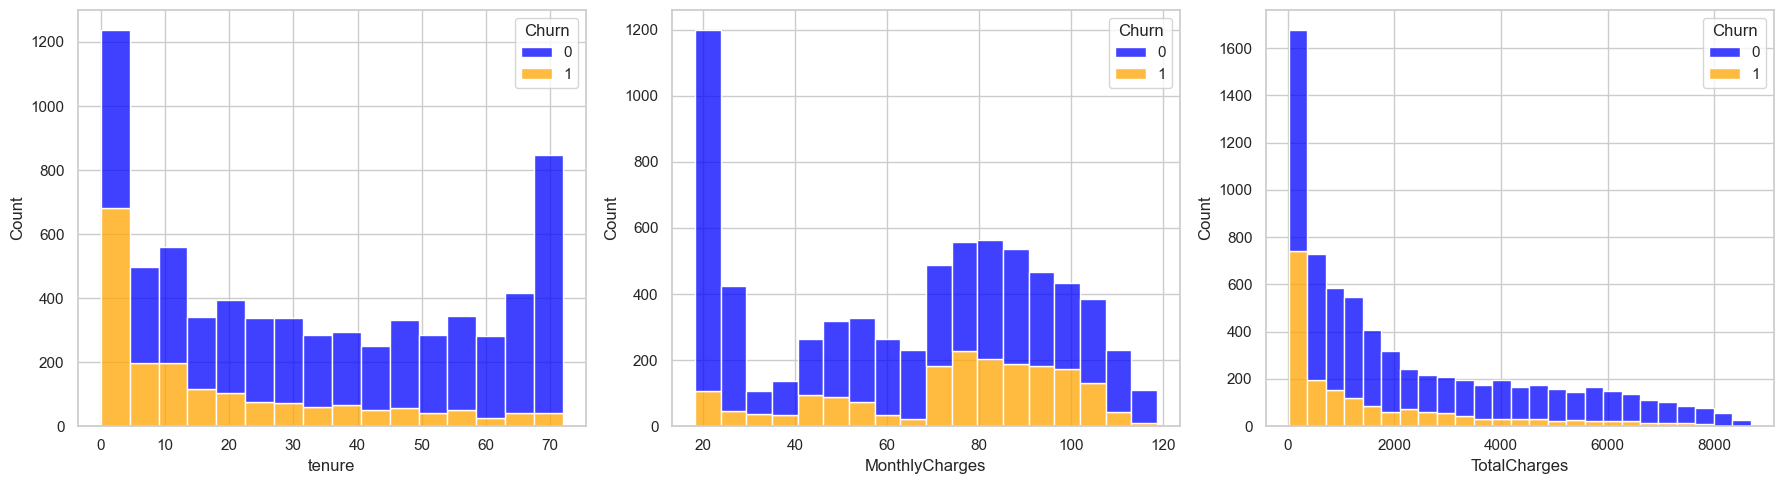

In [12]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
palette = {0: "blue", 1: "orange"}

sns.histplot(data=data, x='tenure', hue='Churn', multiple="stack", palette=palette, ax=axes[0])
sns.histplot(data=data, x='MonthlyCharges', hue='Churn', multiple="stack", palette=palette, ax=axes[1])
sns.histplot(data=data, x='TotalCharges', hue='Churn', multiple="stack", palette=palette, ax=axes[2])

plt.tight_layout()
plt.show()

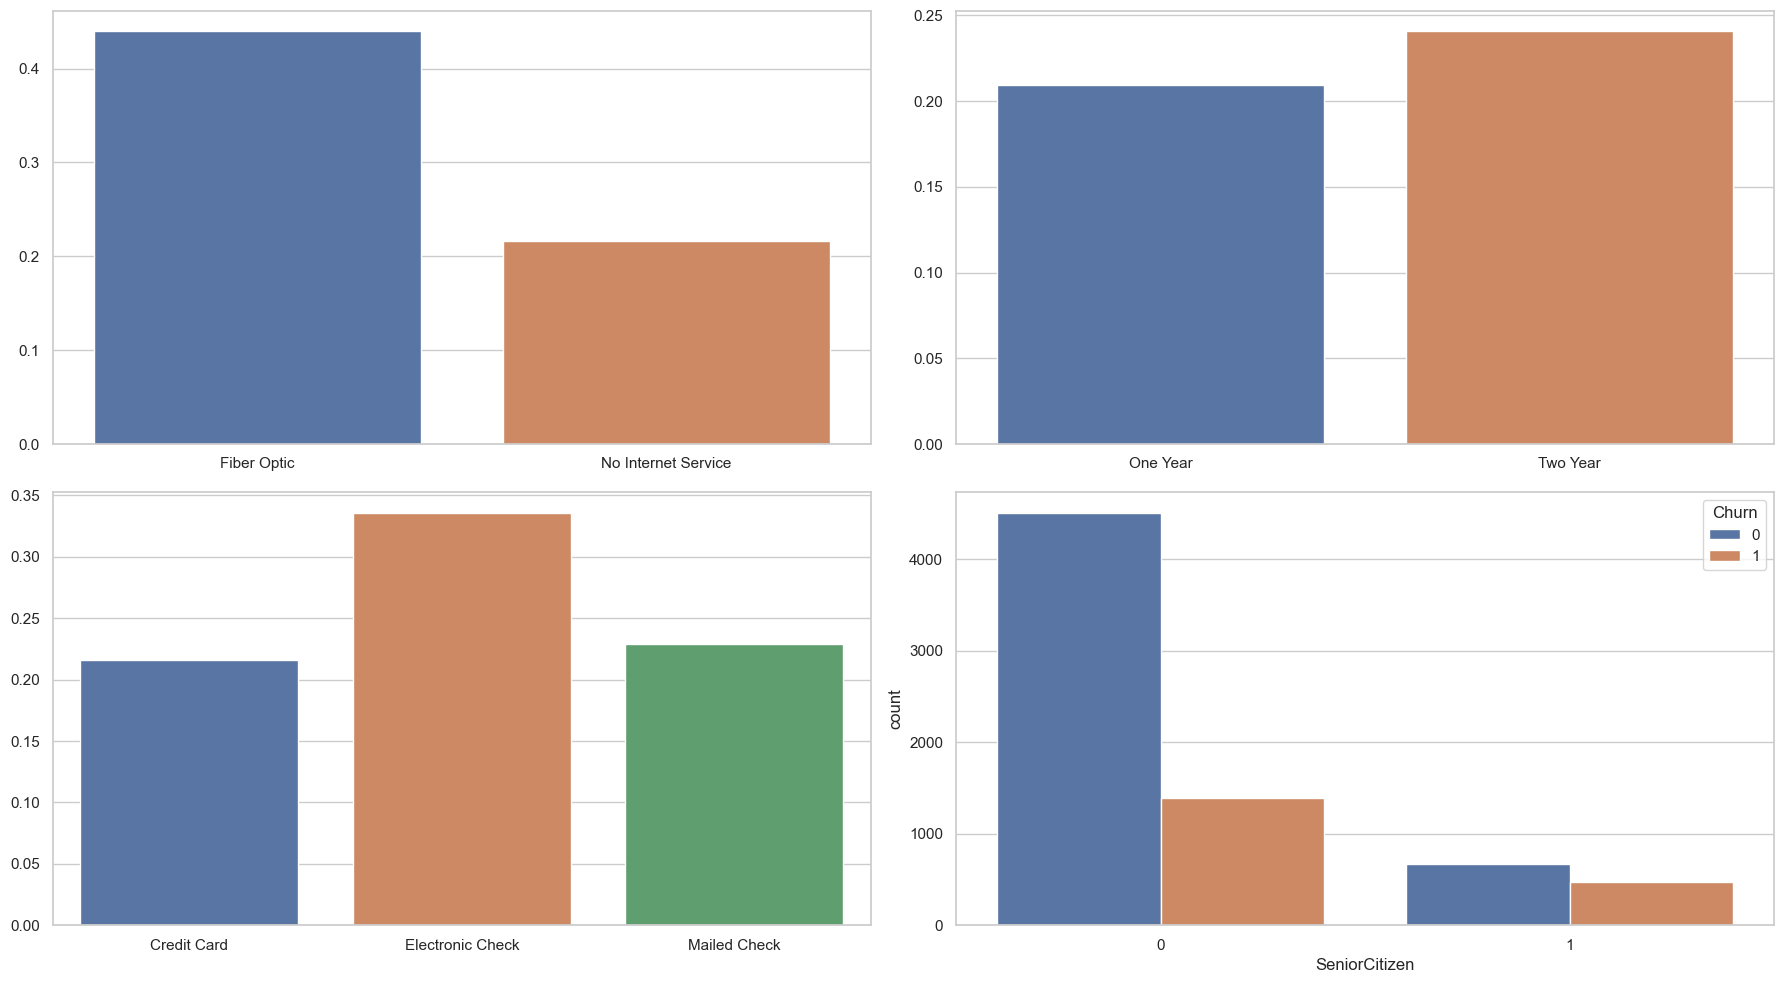

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.barplot(x=['Fiber Optic', 'No Internet Service'], 
            y=[data['InternetService_Fiber optic'].mean(), data['InternetService_No'].mean()], 
            ax=axes[0, 0])
sns.barplot(x=['One Year', 'Two Year'], 
            y=[data['Contract_One year'].mean(), data['Contract_Two year'].mean()], 
            ax=axes[0, 1])
sns.barplot(x=['Credit Card', 'Electronic Check', 'Mailed Check'], 
            y=[data['PaymentMethod_Credit card (automatic)'].mean(), 
                data['PaymentMethod_Electronic check'].mean(), 
                data['PaymentMethod_Mailed check'].mean()], 
            ax=axes[1, 0])
sns.countplot(x='SeniorCitizen', hue='Churn', data=data, ax=axes[1, 1])
plt.tight_layout()
plt.show()

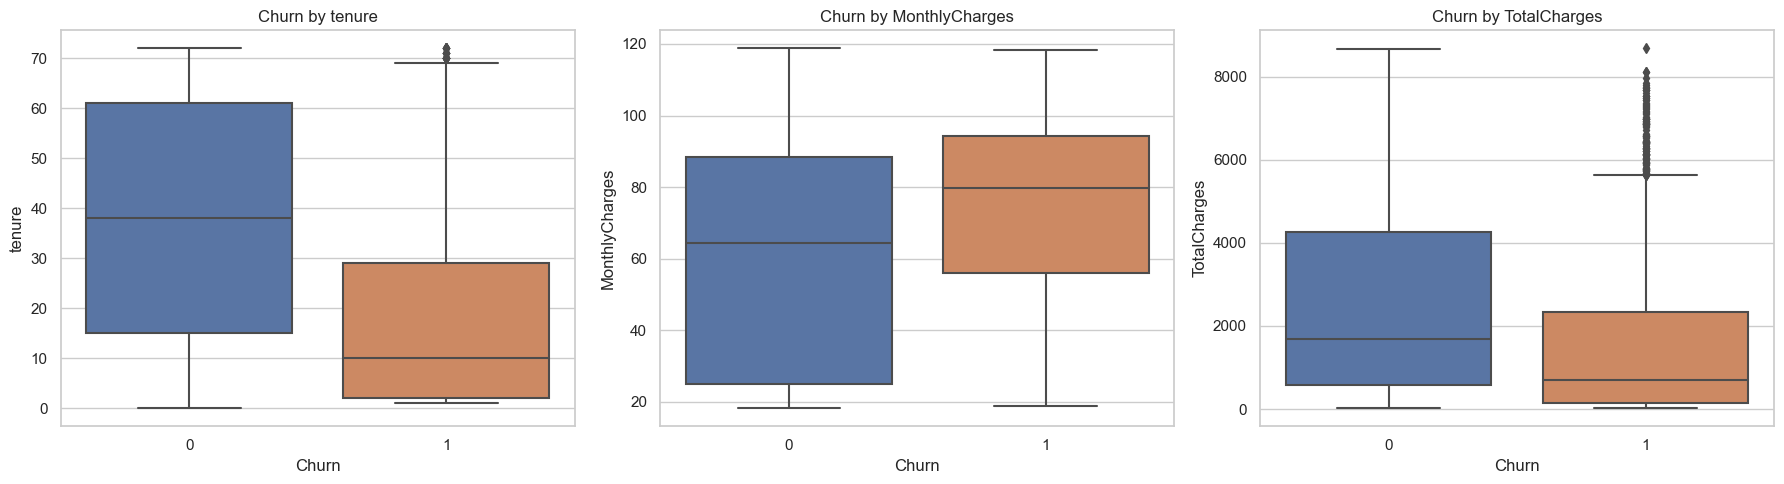

In [14]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(nrows=1, ncols=len(numerical_features), figsize=(18, 5))

# Makes a box plot
for i, col in enumerate(numerical_features):
    sns.boxplot(x='Churn', y=col, data=data, ax=axes[i])
    axes[i].set_title(f'Churn by {col}')

plt.tight_layout()
plt.show()

In [15]:
# Categories from the 'InternetService' feature
internet_service_churn_rates = {
    'Fiber Optic': data['InternetService_Fiber optic'][data['Churn'] == 1].mean(),
    'No Internet Service': data['InternetService_No'][data['Churn'] == 1].mean(),
    # Assuming there's another category like DSL which will be inferred
    'DSL': 1 - (data['InternetService_Fiber optic'][data['Churn'] == 1].mean() + 
                 data['InternetService_No'][data['Churn'] == 1].mean())
}

# Categories from the 'Contract' feature
contract_churn_rates = {
    'One Year': data['Contract_One year'][data['Churn'] == 1].mean(),
    'Two Year': data['Contract_Two year'][data['Churn'] == 1].mean(),
    # Assuming Month-to-month is the base category
    'Month-to-month': 1 - (data['Contract_One year'][data['Churn'] == 1].mean() + 
                            data['Contract_Two year'][data['Churn'] == 1].mean())
}

# Categories from the 'PaymentMethod' feature
payment_method_churn_rates = {
    'Credit Card': data['PaymentMethod_Credit card (automatic)'][data['Churn'] == 1].mean(),
    'Electronic Check': data['PaymentMethod_Electronic check'][data['Churn'] == 1].mean(),
    'Mailed Check': data['PaymentMethod_Mailed check'][data['Churn'] == 1].mean(),
    # Assuming another payment method such as bank transfer is the base category
    'Bank Transfer': 1 - (data['PaymentMethod_Credit card (automatic)'][data['Churn'] == 1].mean() +
                          data['PaymentMethod_Electronic check'][data['Churn'] == 1].mean() +
                          data['PaymentMethod_Mailed check'][data['Churn'] == 1].mean())
}

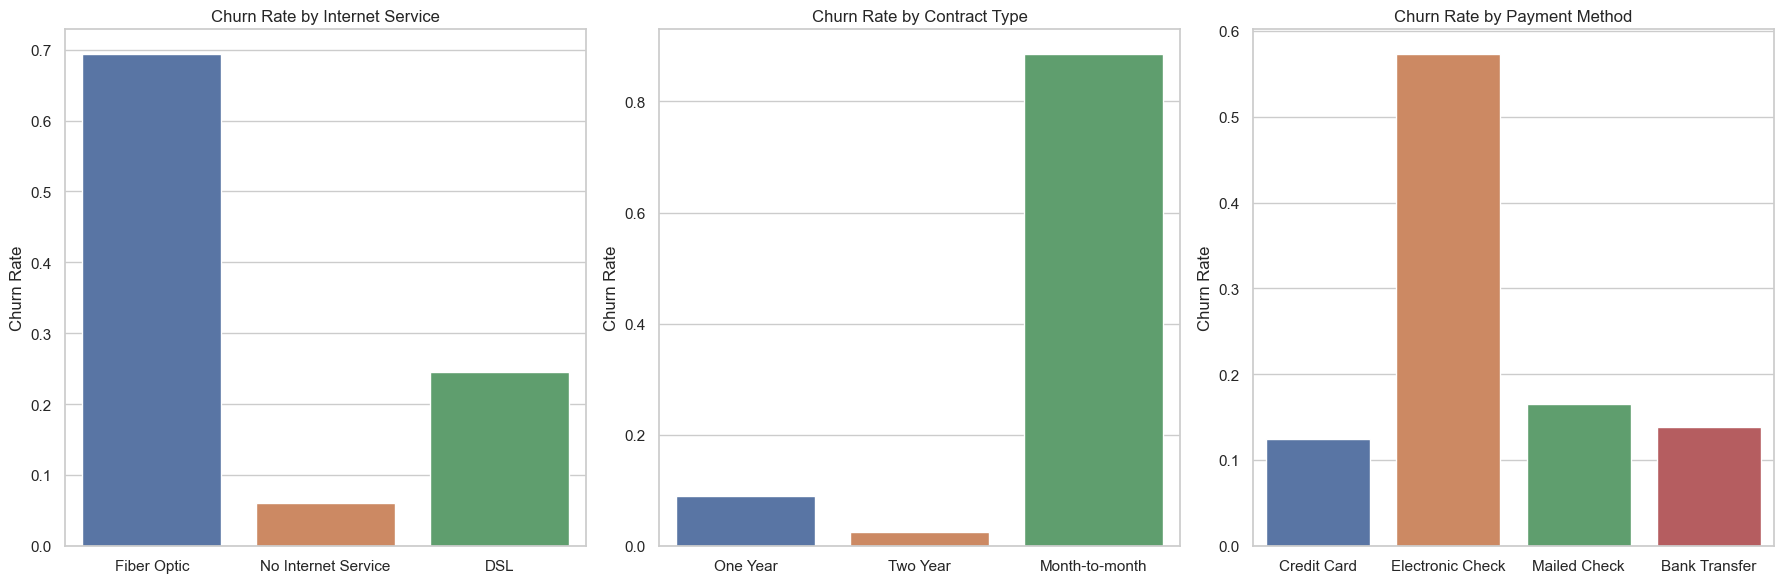

In [16]:
# Plots them
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(x=list(internet_service_churn_rates.keys()), y=list(internet_service_churn_rates.values()), ax=ax[0])
ax[0].set_title('Churn Rate by Internet Service')
ax[0].set_ylabel('Churn Rate')

sns.barplot(x=list(contract_churn_rates.keys()), y=list(contract_churn_rates.values()), ax=ax[1])
ax[1].set_title('Churn Rate by Contract Type')
ax[1].set_ylabel('Churn Rate')

sns.barplot(x=list(payment_method_churn_rates.keys()), y=list(payment_method_churn_rates.values()), ax=ax[2])
ax[2].set_title('Churn Rate by Payment Method')
ax[2].set_ylabel('Churn Rate')

plt.tight_layout()
plt.show()

### Correlation Matrix

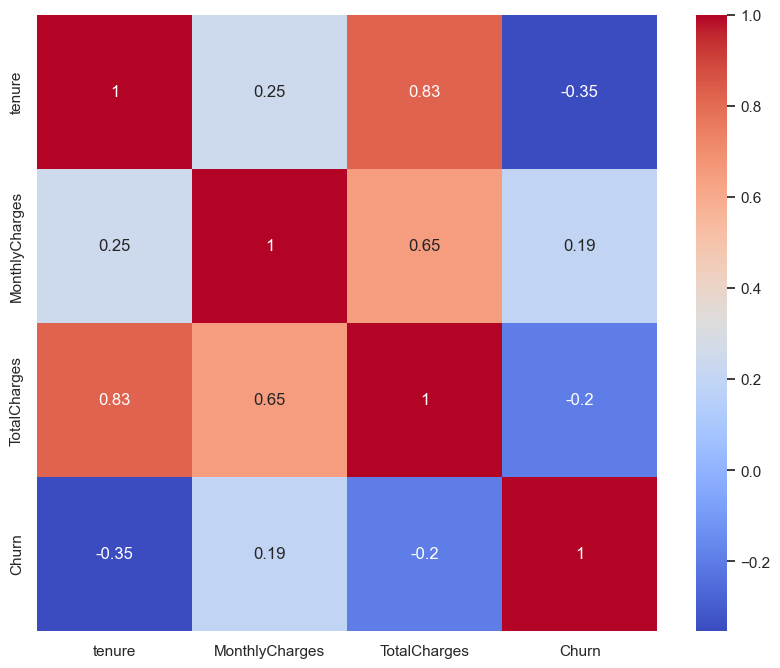

In [17]:
plt.figure(figsize=(10, 8))
correlation = data[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

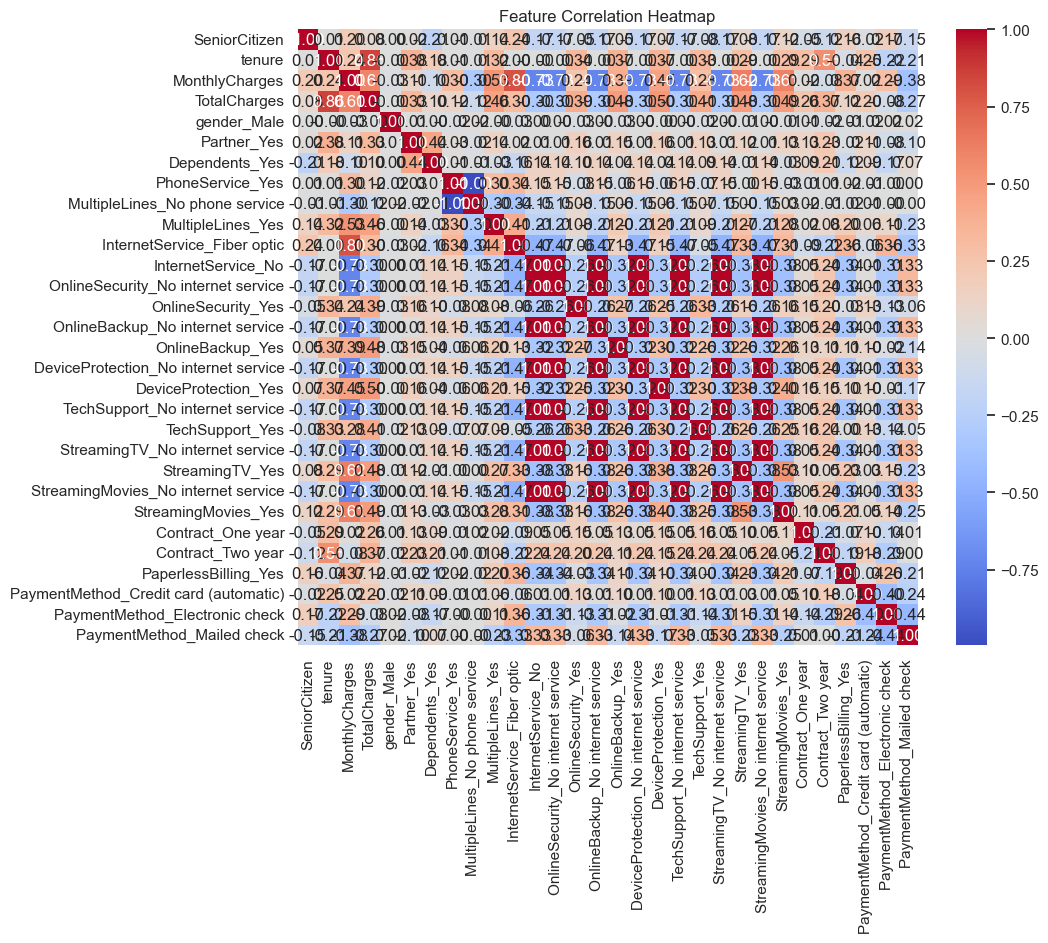

In [19]:
corr = X_train_smote.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [20]:
# Calculates the overall churn rate
churn_rate = data['Churn'].mean()

print(f"The overall churn rate is: {churn_rate:.2%}")

The overall churn rate is: 26.54%


#### Identifying Outliers

In [21]:
# Calculates the z-scores 
data['z_score_tenure'] = np.abs(stats.zscore(data['tenure']))
data['z_score_monthly_charges'] = np.abs(stats.zscore(data['MonthlyCharges']))
data['z_score_total_charges'] = np.abs(stats.zscore(data['TotalCharges']))

threshold = 3

# Identify outliers
outliers_tenure = data[data['z_score_tenure'] > threshold]
outliers_monthly_charges = data[data['z_score_monthly_charges'] > threshold]
outliers_total_charges = data[data['z_score_total_charges'] > threshold]

print(f"Outliers in 'tenure': {outliers_tenure.shape[0]}")
print(f"Outliers in 'MonthlyCharges': {outliers_monthly_charges.shape[0]}")
print(f"Outliers in 'TotalCharges': {outliers_total_charges.shape[0]}")

Outliers in 'tenure': 0
Outliers in 'MonthlyCharges': 0
Outliers in 'TotalCharges': 0


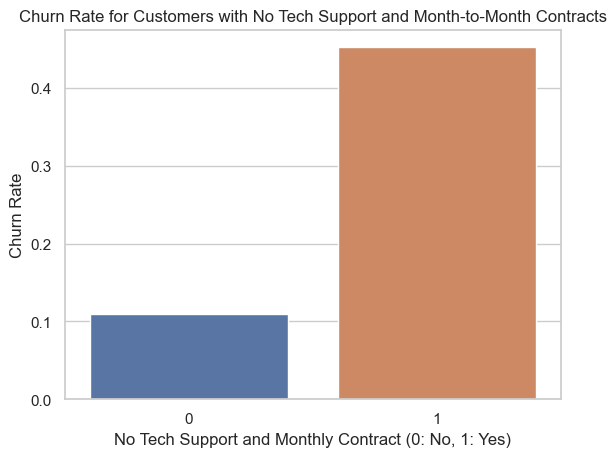

In [22]:
data['NoTechSupport_MonthlyContract'] = (
    (~data['TechSupport_Yes'].astype(bool)) &
    (~data['Contract_One year'].astype(bool)) & 
    (~data['Contract_Two year'].astype(bool))
).astype(int)

churn_rate_combination = data.groupby('NoTechSupport_MonthlyContract')['Churn'].mean().reset_index()

sns.barplot(x='NoTechSupport_MonthlyContract', y='Churn', data=churn_rate_combination)
plt.title('Churn Rate for Customers with No Tech Support and Month-to-Month Contracts')
plt.xlabel('No Tech Support and Monthly Contract (0: No, 1: Yes)')
plt.ylabel('Churn Rate')
plt.show()

#### Preprocessing and Splitting Data into Sets

#### Logistic Regression Model (With SMOTE)

In [72]:
model = LogisticRegression(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1036
           1       0.54      0.75      0.63       373

    accuracy                           0.76      1409
   macro avg       0.72      0.76      0.73      1409
weighted avg       0.80      0.76      0.77      1409

Confusion Matrix:
[[793 243]
 [ 92 281]]


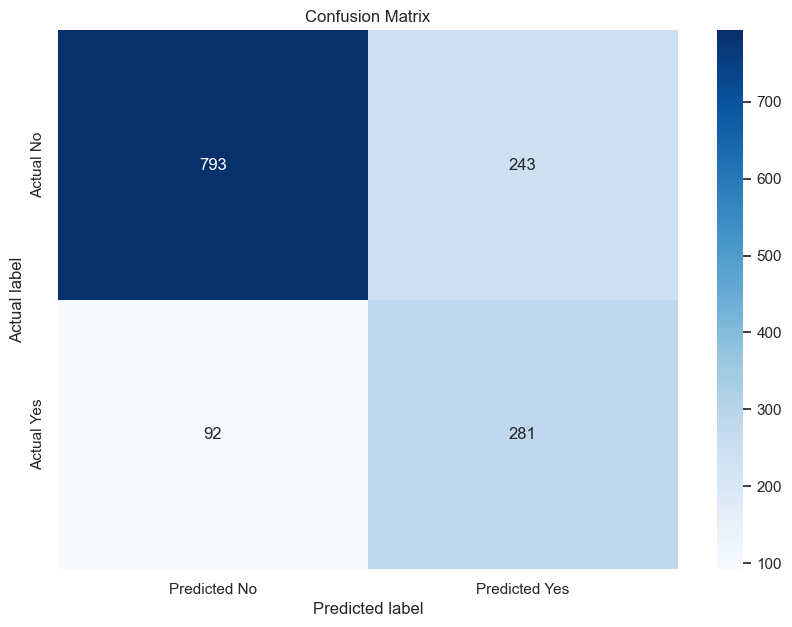

In [74]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

#### Logistic Regression Model

In [24]:
model = LogisticRegression()

# Uses training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.69      0.60      0.64       373

    accuracy                           0.82      1409
   macro avg       0.77      0.75      0.76      1409
weighted avg       0.82      0.82      0.82      1409

[[934 102]
 [150 223]]


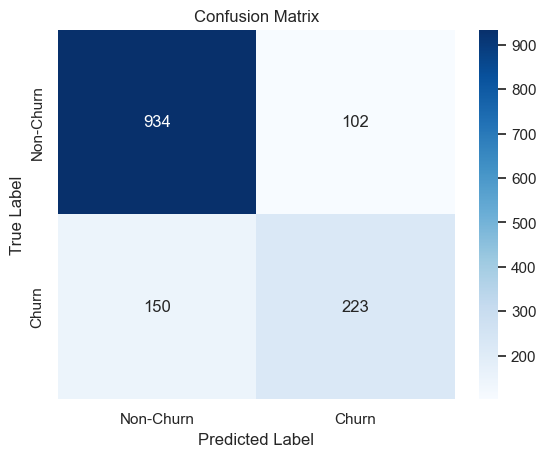

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

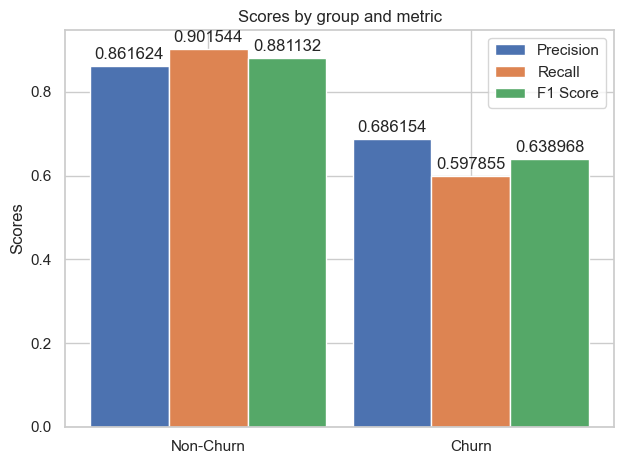

In [26]:
# Plots the results
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred)

labels = ['Non-Churn', 'Churn']

x = np.arange(len(labels))  
width = 0.3 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, fscore, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()

#### Random Forest Model

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.4s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.6s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=100; total time=   0.1

[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=200; total time=   0.4s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   0.7s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   0.8s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.3s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, ma

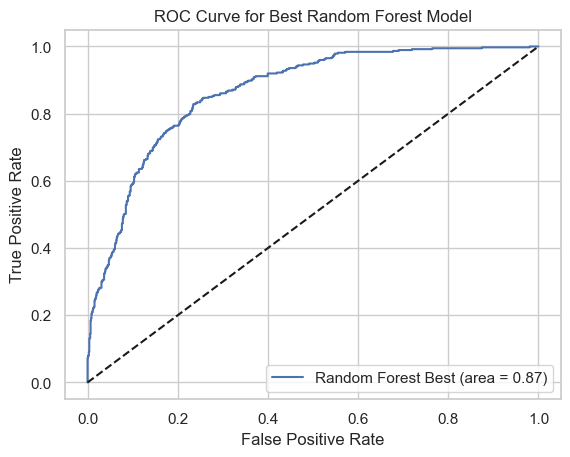

In [27]:
rf_model = RandomForestClassifier(random_state=42)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

# Using grid search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)
grid_search.fit(X_train, y_train)

# Sows the best parametersd idenfitified
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Trains the model on the paramsa
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

y_probs_best = best_rf_model.predict_proba(X_test)[:, 1]  

# Calculates the ROC-AUC score
roc_auc_best = roc_auc_score(y_test, y_probs_best)
print(f"ROC-AUC Score of Best Model: {roc_auc_best}")
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_probs_best)

plt.figure()
plt.plot(fpr_best, tpr_best, label='Random Forest Best (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc="lower right")
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.88      1036
           1       0.69      0.49      0.57       373

    accuracy                           0.81      1409
   macro avg       0.76      0.71      0.72      1409
weighted avg       0.80      0.81      0.80      1409



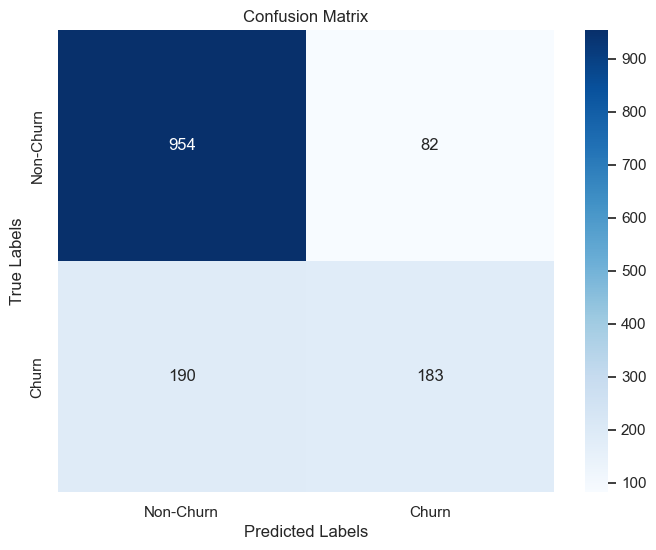

In [28]:
y_pred = best_rf_model.predict(X_test)

class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

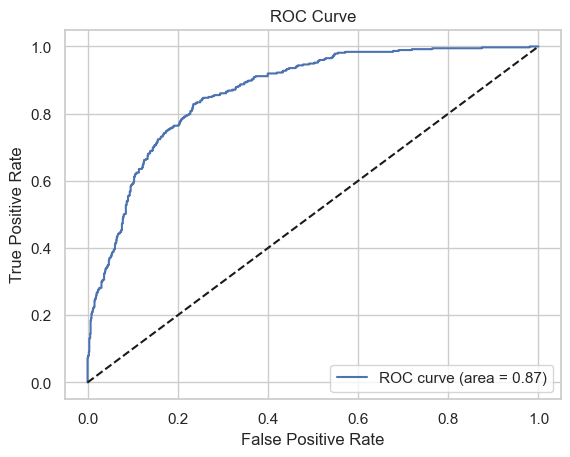

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, best_rf_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

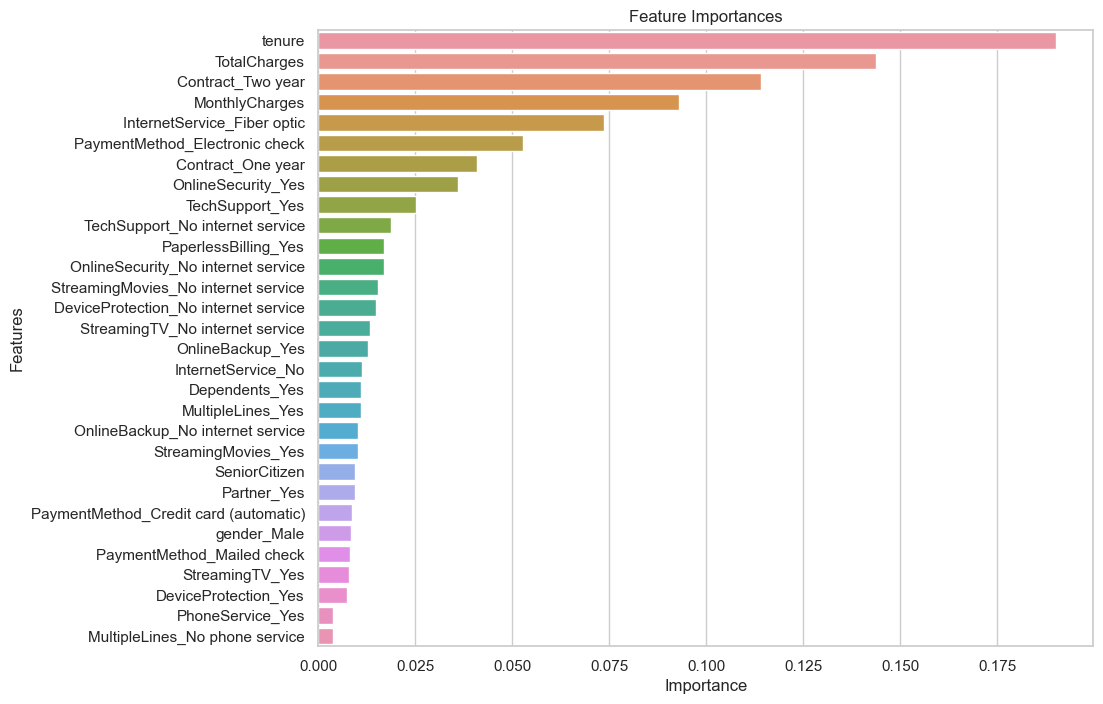

In [30]:
feature_importances = best_rf_model.feature_importances_
features = X_train.columns
importance_df = pd.DataFrame({'Features': features, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Features')
plt.title('Feature Importances')
plt.show()

#### Random Forest Model Training (WITHOUT GRIDSEARCH)

ROC-AUC Score: 0.8378287805231505


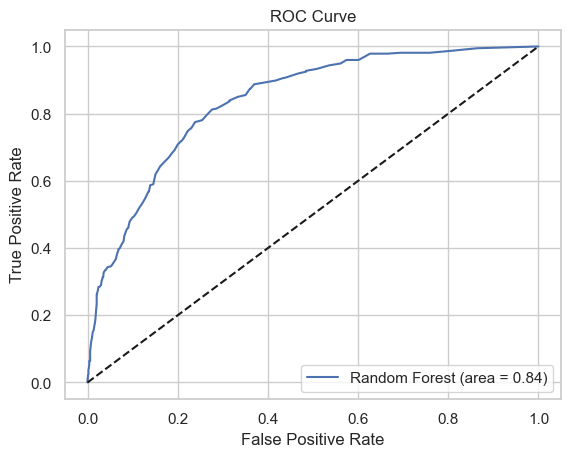

In [31]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculates the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [32]:
y_pred = rf_model.predict(X_test)

report = classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn'])
print(report)

              precision    recall  f1-score   support

   Non-Churn       0.82      0.91      0.87      1036
       Churn       0.65      0.46      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



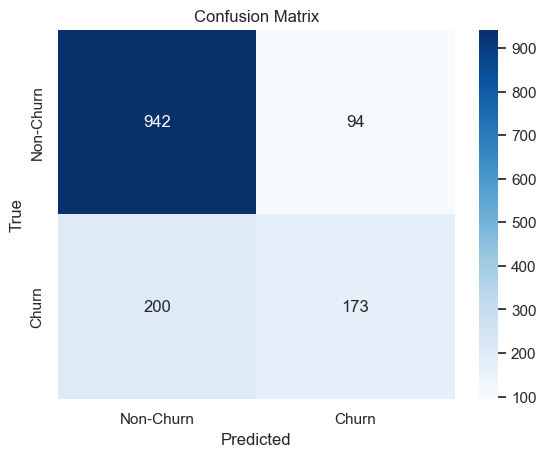

In [33]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### XgBOOST Modelling

In [34]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='roc_auc', verbose=2)

grid_search_xgb.fit(X_train, y_train)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best score:", grid_search_xgb.best_score_)

best_xgb_model = grid_search_xgb.best_estimator_
y_probs_xgb = best_xgb_model.predict_proba(X_test)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)
print(f"ROC-AUC Score of Best XGBoost Model: {roc_auc_xgb}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200,

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100,

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best score: 0.8445414025946588
ROC-AUC Score of Best XGBoost Model: 0.8643

In [35]:
y_pred_xgb = best_xgb_model.predict(X_test)

report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Non-Churn', 'Churn'])
print("Classification Report for XGBoost:")
print(report_xgb)

Classification Report for XGBoost:
              precision    recall  f1-score   support

   Non-Churn       0.84      0.92      0.88      1036
       Churn       0.70      0.51      0.59       373

    accuracy                           0.81      1409
   macro avg       0.77      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



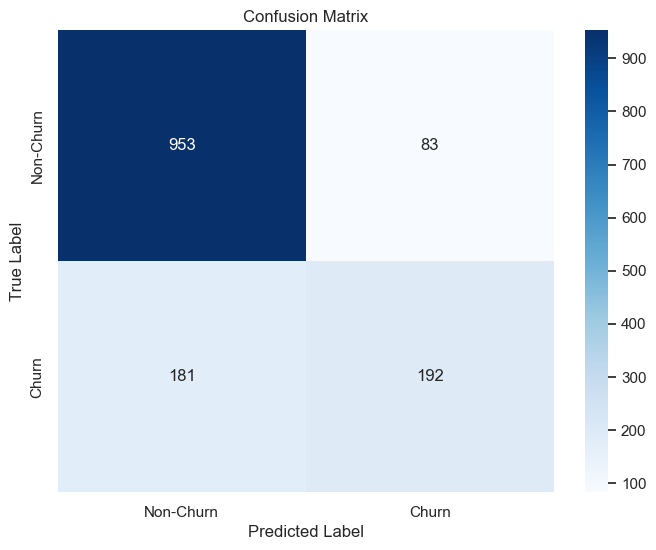

In [36]:
y_pred = best_xgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

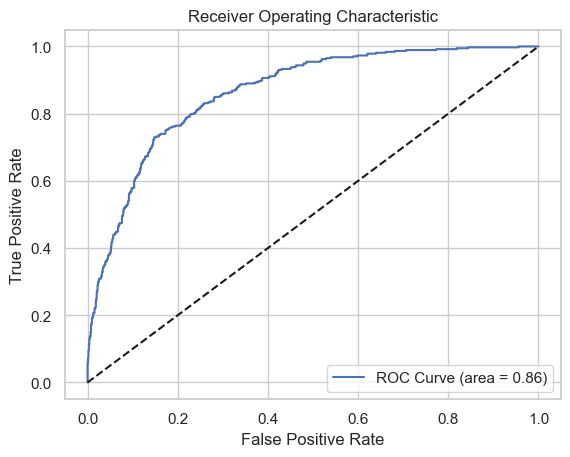

In [37]:
y_probs = best_xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

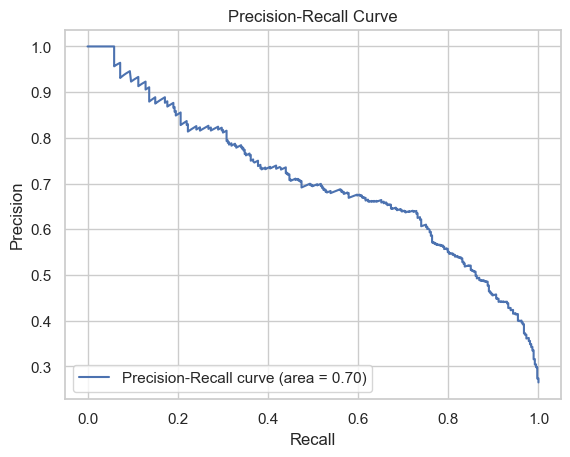

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

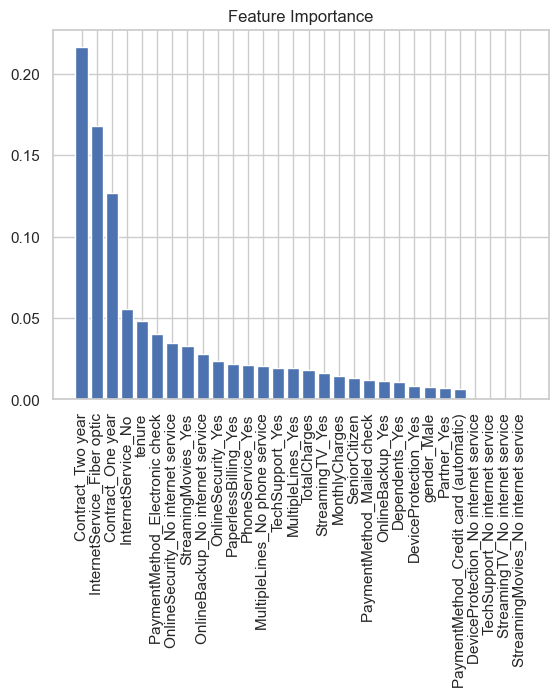

In [39]:
feature_importances = best_xgb_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
names = [X_train.columns[i] for i in indices]

plt.figure()
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), feature_importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.show()

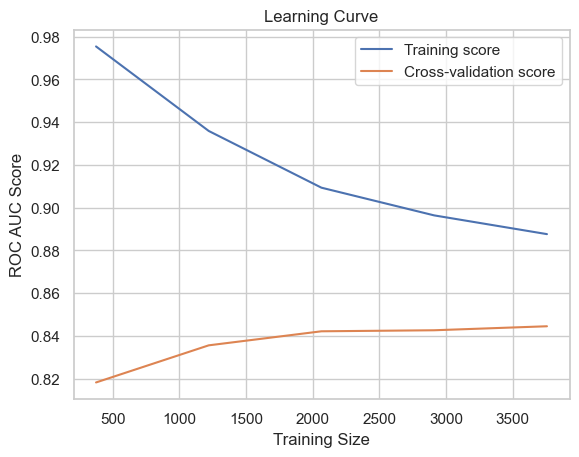

In [40]:
train_sizes, train_scores, validation_scores = learning_curve(best_xgb_model, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 5), cv=3, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, label='Training score')
plt.plot(train_sizes, validation_scores_mean, label='Cross-validation score')
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC Score')
plt.legend(loc="best")
plt.show()

#### SVM (Support Vector Machine) Model

In [41]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# The pipeline with a standard scaler
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 'auto'],
    'svm__kernel': ['rbf', 'linear']  
}

grid_search_svm = GridSearchCV(estimator=pipeline, param_grid=param_grid_svm, cv=3, scoring='roc_auc', verbose=2)

grid_search_svm.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   2.8s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   2.8s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   2.7s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   1.6s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   1.6s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   1.6s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   2.8s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   2.7s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   2.7s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   1.6s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   1.6s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__k

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(probability=True))]),
             param_grid={'svm__C': [0.1, 1, 10],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='roc_auc', verbose=2)

Best parameters: {'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best score: 0.8295034628681455
ROC-AUC Score: 0.8152320742803316


S:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


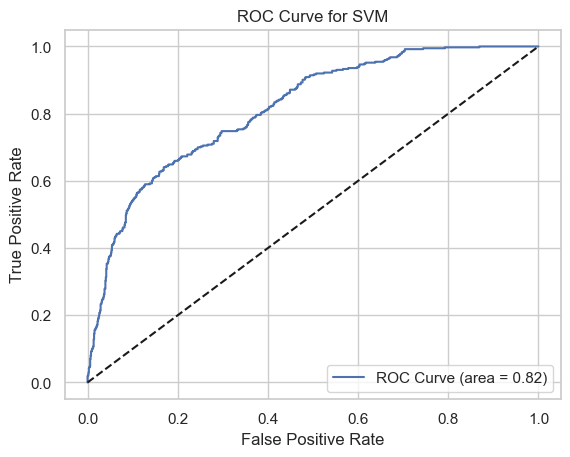

In [43]:
# Print best parameters and best score
print("Best parameters:", grid_search_svm.best_params_)
print("Best score:", grid_search_svm.best_score_)

# Get the best estimator
best_svm_model = grid_search_svm.best_estimator_

# Predict probabilities on the test set
y_probs = best_svm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc}")

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # This is the random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

ROC-AUC Score: 0.852152276750132


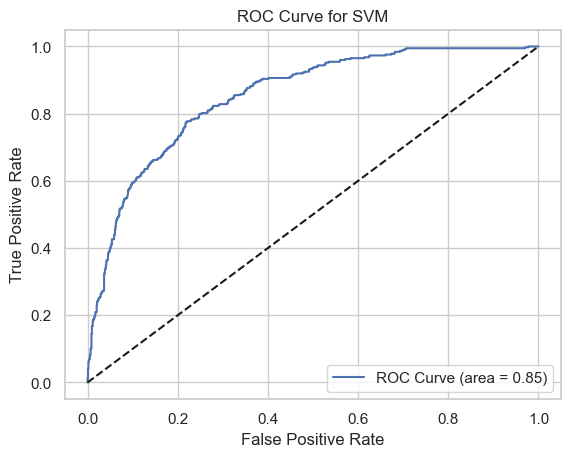

In [44]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True, C=10, gamma='scale', kernel='linear'))
])

pipeline.fit(X_train, y_train)

y_probs = pipeline.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC Score: {roc_auc}")

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVM')
plt.legend(loc="lower right")
plt.show()

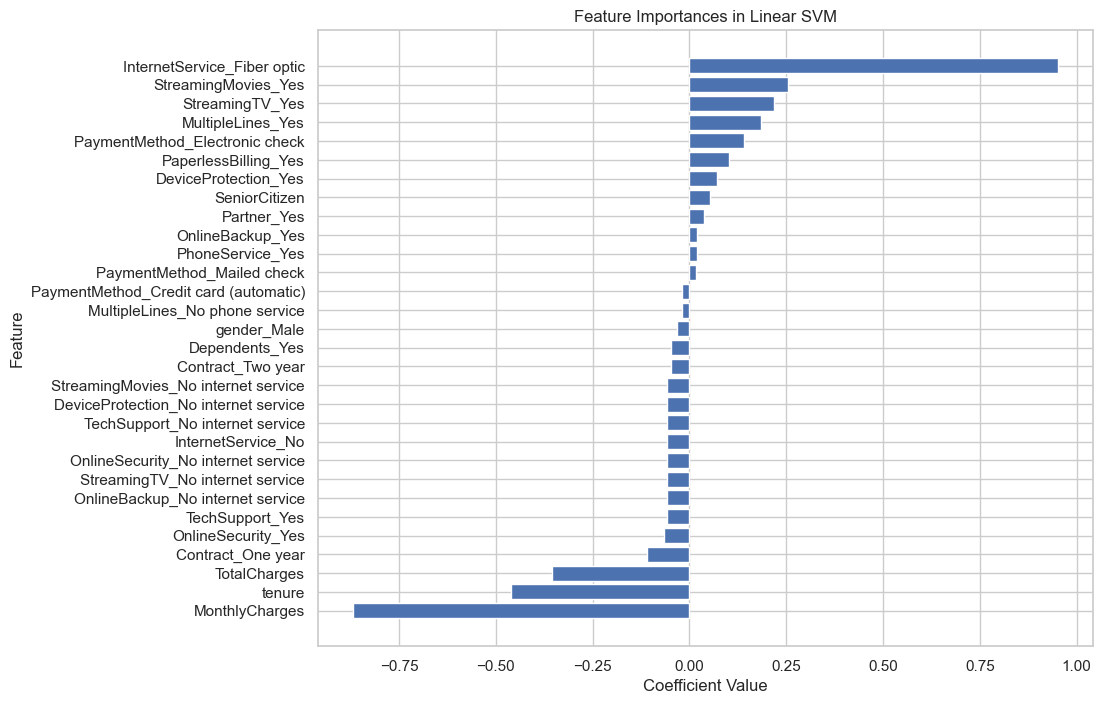

In [45]:
if 'linear' in grid_search_svm.best_params_['svm__kernel']:
    coef = grid_search_svm.best_estimator_.named_steps['svm'].coef_.flatten()
    # Plotting
    plt.figure(figsize=(10, 8))
    indices = np.argsort(coef)
    plt.barh(np.array(features)[indices], coef[indices])
    plt.xlabel("Coefficient Value")
    plt.ylabel("Feature")
    plt.title("Feature Importances in Linear SVM")
    plt.show()

S:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


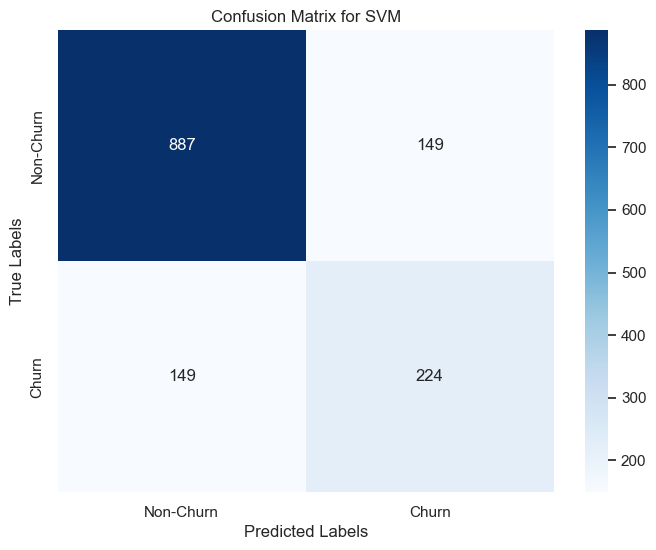

In [46]:
y_pred = best_svm_model.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'])
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [47]:
report = classification_report(y_test, y_pred, target_names=['Non-Churn', 'Churn'])
print(report)

              precision    recall  f1-score   support

   Non-Churn       0.86      0.86      0.86      1036
       Churn       0.60      0.60      0.60       373

    accuracy                           0.79      1409
   macro avg       0.73      0.73      0.73      1409
weighted avg       0.79      0.79      0.79      1409



S:\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


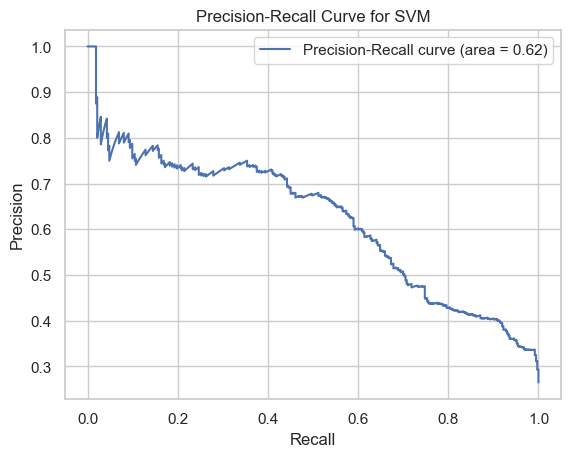

In [48]:
precision, recall, _ = precision_recall_curve(y_test, best_svm_model.decision_function(X_test_scaled))
pr_auc = auc(recall, precision)

plt.figure()
plt.plot(recall, precision, label='Precision-Recall curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVM')
plt.legend(loc="best")
plt.show()

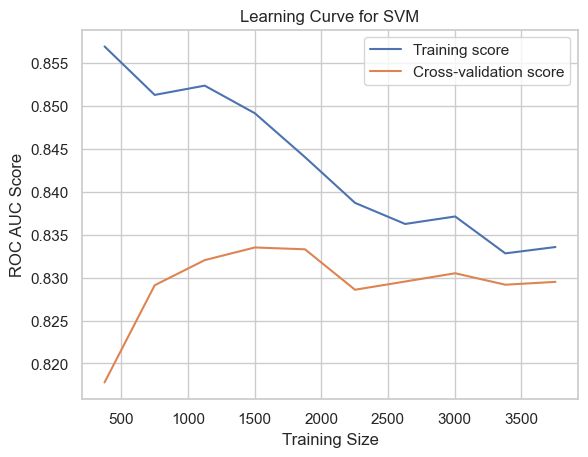

In [50]:
train_sizes, train_scores, test_scores = learning_curve(best_svm_model, X_train_scaled, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=3, scoring='roc_auc')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.title('Learning Curve for SVM')
plt.xlabel('Training Size')
plt.ylabel('ROC AUC Score')
plt.legend(loc='best')
plt.show()

### Random Forest Classifier (With SMOTE)

In [51]:
rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=2)

grid_search.fit(X_train_smote, y_train_smote)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200; total time=   0.5s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.8s
[CV] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=300; total time=   0.7s
[CV] END criterion=gini, max_depth=4, max_features=log2, n_estimators=100; total time=   0.2

[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=200; total time=   0.6s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   1.0s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=entropy, max_depth=6, max_features=log2, n_estimators=300; total time=   0.9s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=100; total time=   0.4s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, max_depth=8, max_features=sqrt, n_estimators=200; total time=   0.8s
[CV] END criterion=entropy, ma

Classification Report for Best Random Forest Model:
              precision    recall  f1-score   support

           0       0.92      0.75      0.83      1036
           1       0.54      0.81      0.65       373

    accuracy                           0.77      1409
   macro avg       0.73      0.78      0.74      1409
weighted avg       0.82      0.77      0.78      1409

ROC-AUC Score of Best Model: 0.8617763205564815


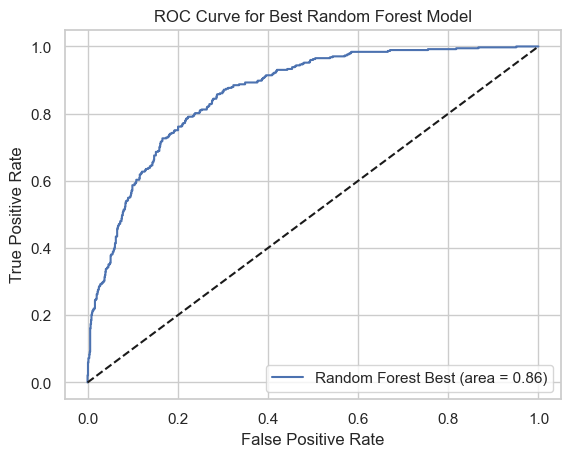

In [52]:
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train_smote, y_train_smote)

y_pred_best = best_rf_model.predict(X_test)

print("Classification Report for Best Random Forest Model:")
print(classification_report(y_test, y_pred_best))

y_probs_best = best_rf_model.predict_proba(X_test)[:, 1]

roc_auc_best = roc_auc_score(y_test, y_probs_best)
print(f"ROC-AUC Score of Best Model: {roc_auc_best}")

fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_probs_best)
plt.figure()
plt.plot(fpr_best, tpr_best, label='Random Forest Best (area = %0.2f)' % roc_auc_best)
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best Random Forest Model')
plt.legend(loc="lower right")
plt.show()

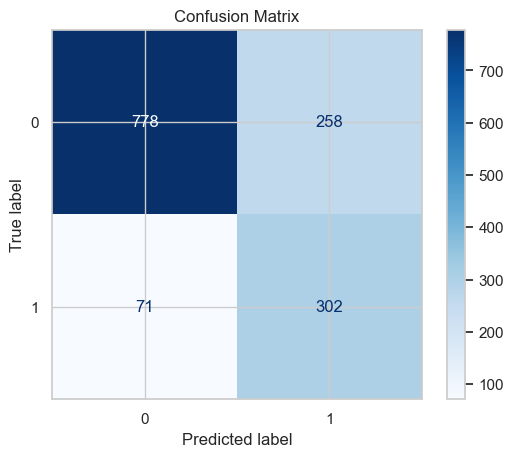

In [53]:
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

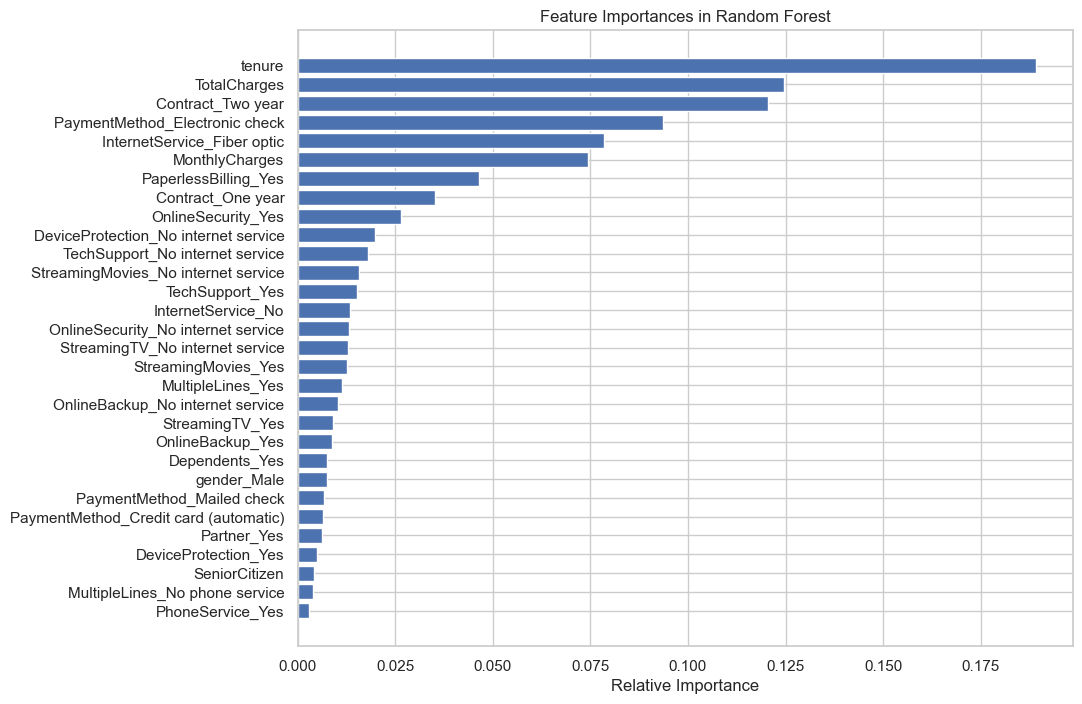

In [68]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances in Random Forest')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

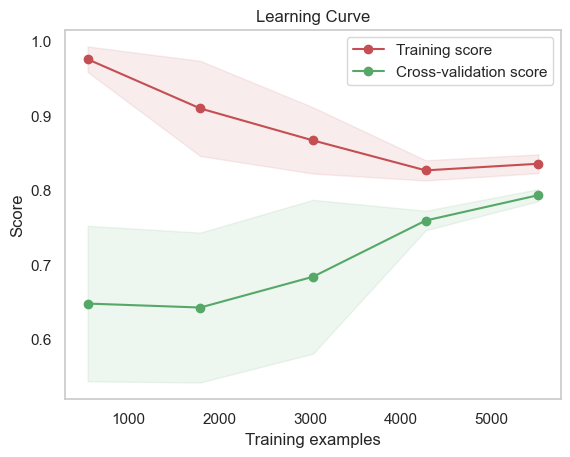

In [55]:
def plot_learning_curve(model, X, y, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(best_rf_model, X_train_smote, y_train_smote)

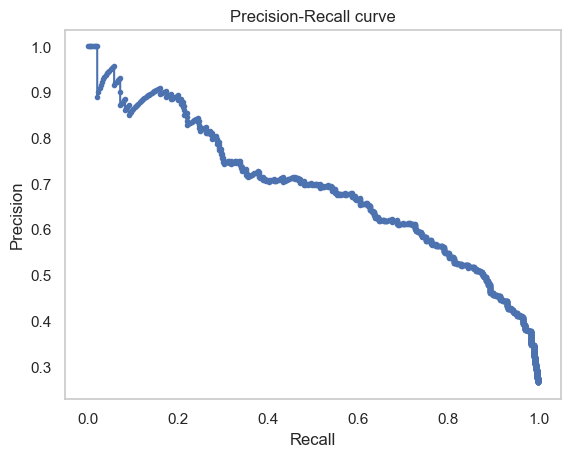

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_best)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

#### XgBOOST Model (With SMOTE)

In [57]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, scoring='roc_auc', verbose=2)

grid_search_xgb.fit(X_train_smote, y_train_smote)

print("Best parameters:", grid_search_xgb.best_params_)
print("Best score:", grid_search_xgb.best_score_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END 

[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estima

[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200,

[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100,

[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.01, max_depth=4, n_estima

[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=4, n_estimators=200,

[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.9, learning_rate=0.2, max_depth=4, n_estimators=100,

[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estima

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200,

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100,

[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300,

ROC-AUC Score of Best XGBoost Model: 0.8217455774426283


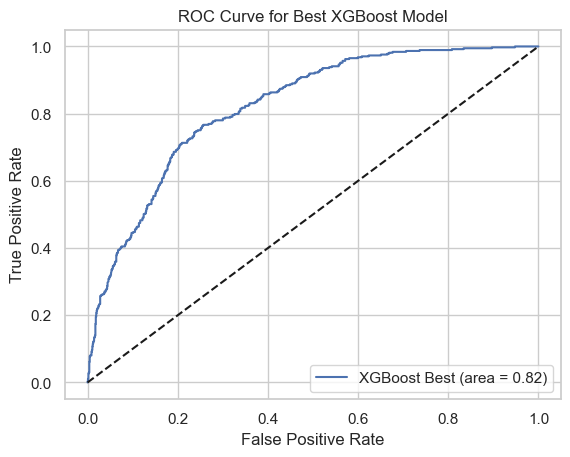

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1036
           1       0.57      0.64      0.60       373

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.77      0.78      1409



In [58]:
best_xgb_model = grid_search_xgb.best_estimator_

y_probs_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

roc_auc_xgb = roc_auc_score(y_test, y_probs_xgb)
print(f"ROC-AUC Score of Best XGBoost Model: {roc_auc_xgb}")

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_probs_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost Best (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best XGBoost Model')
plt.legend(loc="lower right")
plt.show()

y_pred_xgb = best_xgb_model.predict(X_test)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_test, y_pred_xgb))

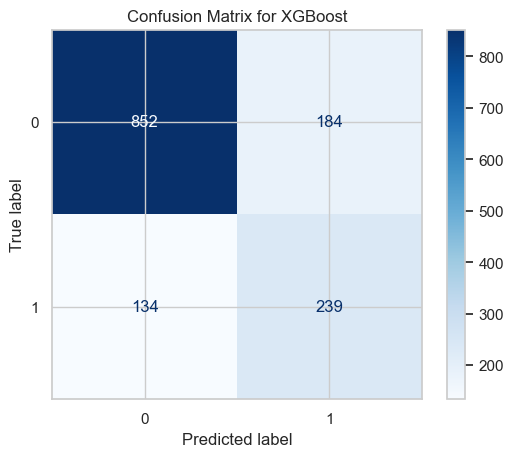

In [59]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost')
plt.show()

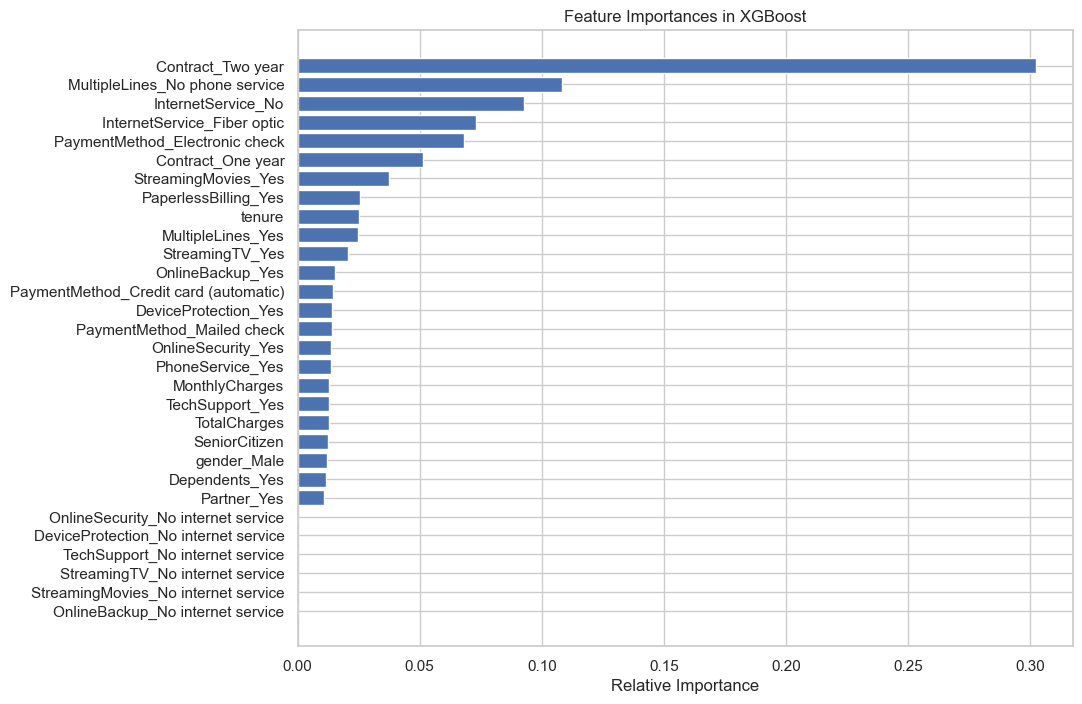

In [69]:
importances_xgb = best_xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)

plt.figure(figsize=(10, 8))
plt.title('Feature Importances in XGBoost')
plt.barh(range(len(indices_xgb)), importances_xgb[indices_xgb], align='center')
plt.yticks(range(len(indices_xgb)), [features[i] for i in indices_xgb])
plt.xlabel('Relative Importance')
plt.show()

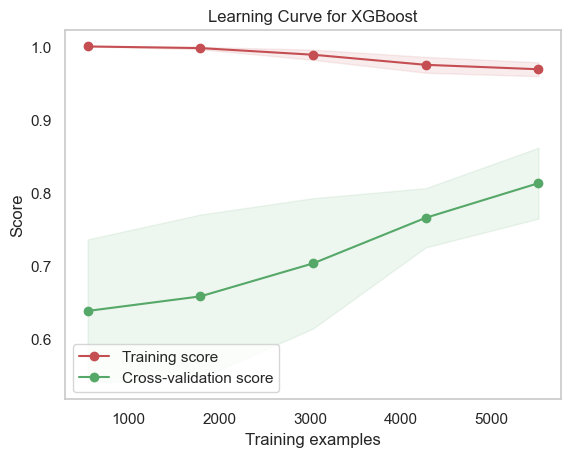

In [61]:
def plot_learning_curve(model, X, y, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve for XGBoost")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(best_xgb_model, X_train_smote, y_train_smote)

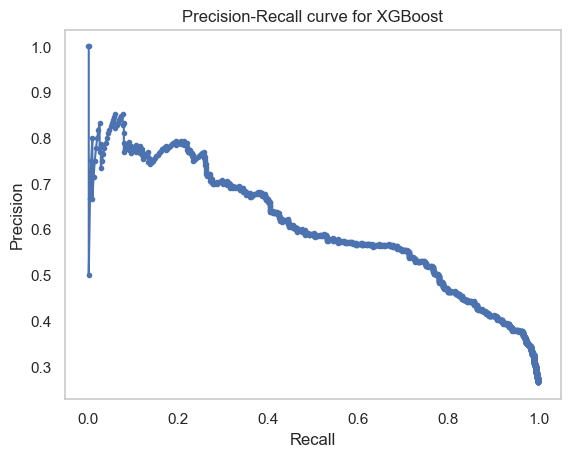

In [62]:
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_probs_xgb)
plt.figure()
plt.plot(recall_xgb, precision_xgb, marker='.')
plt.title('Precision-Recall curve for XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

#### SVM Model (With SMOTE)

In [63]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(probability=True))
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search_svm = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_svm,
    cv=stratified_kfold,
    scoring='roc_auc',
    verbose=2
)

grid_search_svm.fit(X_train_smote, y_train_smote)

print("Best parameters:", grid_search_svm.best_params_)
print("Best score:", grid_search_svm.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   3.8s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   3.9s
[CV] END ...svm__C=0.1, svm__gamma=scale, svm__kernel=linear; total time=   3.9s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   6.7s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   6.6s
[CV] END ......svm__C=0.1, svm__gamma=scale, svm__kernel=rbf; total time=   7.0s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   3.8s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   3.8s
[CV] END ....svm__C=0.1, svm__gamma=auto, svm__kernel=linear; total time=   3.9s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   6.7s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm__kernel=rbf; total time=   6.8s
[CV] END .......svm__C=0.1, svm__gamma=auto, svm

ROC-AUC Score of Best SVM Model: 0.8154701522663989


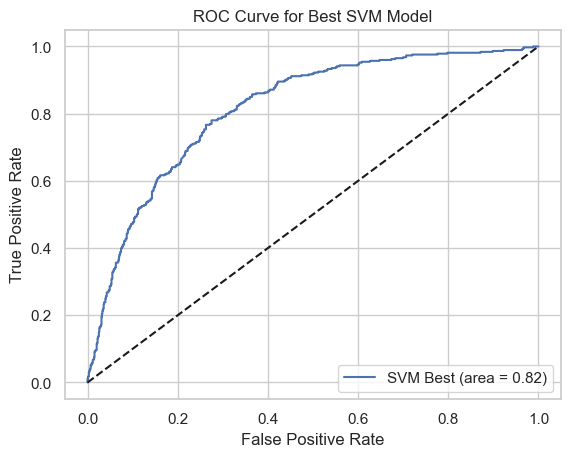

Classification Report for Best SVM Model:
              precision    recall  f1-score   support

           0       0.88      0.76      0.82      1036
           1       0.52      0.71      0.60       373

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.78      0.75      0.76      1409



In [64]:
best_svm_model = grid_search_svm.best_estimator_

y_probs_svm = best_svm_model.predict_proba(X_test)[:, 1]

roc_auc_svm = roc_auc_score(y_test, y_probs_svm)
print(f"ROC-AUC Score of Best SVM Model: {roc_auc_svm}")

fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_probs_svm)
plt.figure()
plt.plot(fpr_svm, tpr_svm, label='SVM Best (area = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Best SVM Model')
plt.legend(loc="lower right")
plt.show()

y_pred_svm = best_svm_model.predict(X_test)
print("Classification Report for Best SVM Model:")
print(classification_report(y_test, y_pred_svm))

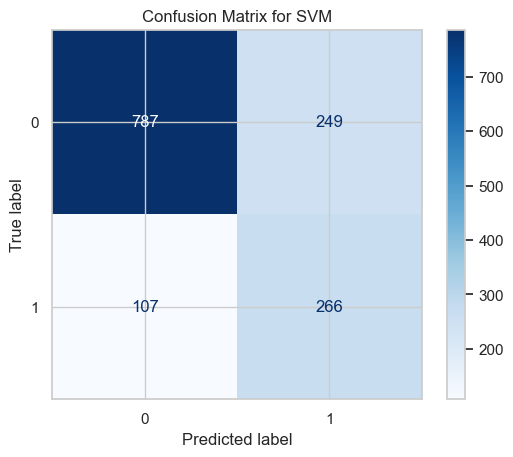

In [65]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()

S:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "S:\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "S:\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "S:\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "S:\anac

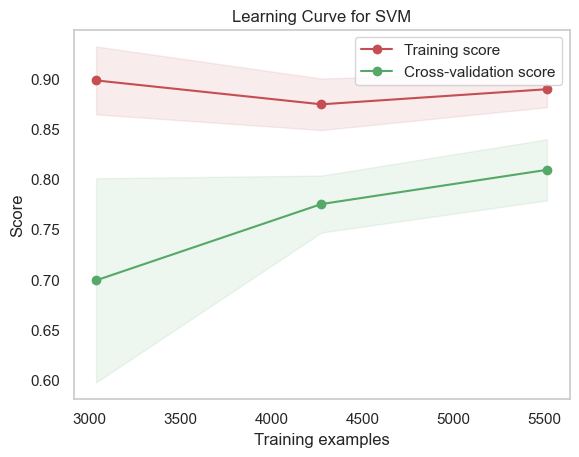

In [66]:
def plot_learning_curve(model, X, y, cv=3):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.title("Learning Curve for SVM")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(best_svm_model, X_train_smote, y_train_smote)

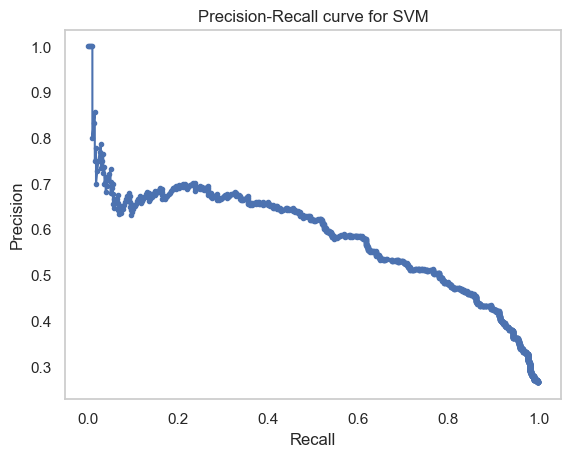

In [67]:
precision_svm, recall_svm, thresholds_svm = precision_recall_curve(y_test, y_probs_svm)
plt.figure()
plt.plot(recall_svm, precision_svm, marker='.')
plt.title('Precision-Recall curve for SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()